<a href="https://colab.research.google.com/github/BrovkoD/ensembles-here-and-there/blob/master/boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Boosting

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

### Load data

In [ ]:
# Load data (8x8 images, 1797 samples, 10 classes)
digits = load_digits()
X, y = digits.data / 16.0, digits.target  # Normalize pixel values to [0, 1]

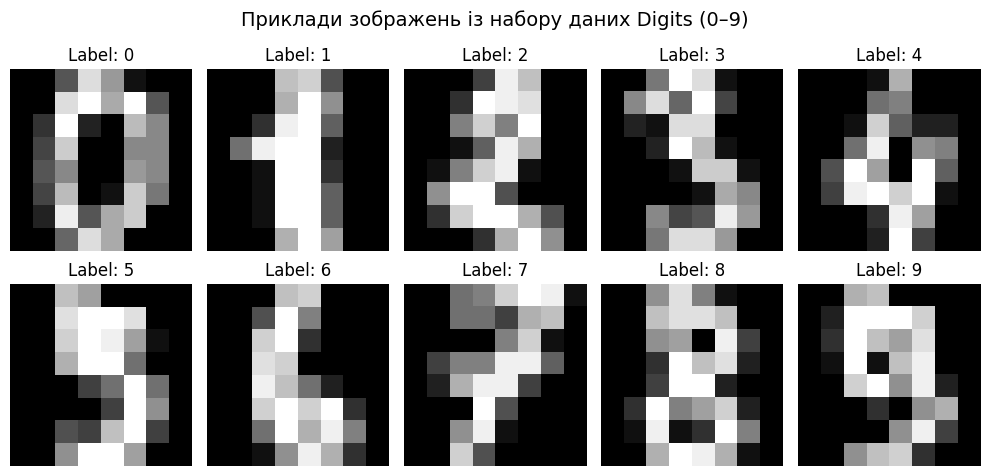

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='gray')
    ax.set_title(f"Label: {digits.target[i]}")
    ax.axis('off')

plt.suptitle("Приклади зображень із набору даних Digits (0–9)", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Split data
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

### Defining weak classifiers and their ensembles

In [ ]:
# Classifiers
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
log_reg = LogisticRegression(max_iter=100, solver='lbfgs', random_state=42)

# Boosting classifiers
ada_tree = AdaBoostClassifier(estimator=tree, n_estimators=50, random_state=42)
ada_log = AdaBoostClassifier(estimator=log_reg, n_estimators=10, random_state=42)
ensemble = VotingClassifier(estimators=[
    ('ada_tree', ada_tree),
    ('ada_log', ada_log),
], voting='soft')

### Training and evaluation of models

In [ ]:
# Fit models
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [ ]:
ada_tree.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    random_state=42),
                   random_state=42)

In [ ]:
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [ ]:
ada_log.fit(X_train, y_train)

AdaBoostClassifier(estimator=LogisticRegression(random_state=42),
                   n_estimators=10, random_state=42)

In [ ]:
ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('ada_tree',
                              AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                                                  random_state=42),
                                                 random_state=42)),
                             ('ada_log',
                              AdaBoostClassifier(estimator=LogisticRegression(random_state=42),
                                                 n_estimators=10,
                                                 random_state=42))],
                 voting='soft')

In [ ]:
def evaluate(model, X_val, y_val, X_test, y_test):
    val_preds = model.predict(X_val)
    test_preds = model.predict(X_test)
    return {
        'Average Accuracy (test)': accuracy_score(y_test, test_preds),
        'Average Accuracy (validation)': accuracy_score(y_val, val_preds),
        'Average Precision (validation)': precision_score(y_val, val_preds, average='macro'),
        'F1 Score': f1_score(y_val, val_preds, average='macro')
    }

# Evaluate
results = {
    'Weak Classifier 1 (Tree)': evaluate(tree, X_val, y_val, X_test, y_test),
    'Ensemble (Tree, AdaBoost)': evaluate(ada_tree, X_val, y_val, X_test, y_test),
    'Weak Classifier 2 (LogReg)': evaluate(log_reg, X_val, y_val, X_test, y_test),
    'Ensemble (LogReg, AdaBoost)': evaluate(ada_log, X_val, y_val, X_test, y_test),
    'Combined Ensemble (AdaBoost Tree + LogReg)': evaluate(ensemble, X_val, y_val, X_test, y_test)
}

# Display table
df_results = pd.DataFrame(results).T

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
df_results

,Average Accuracy (test),Average Accuracy (validation),Average Precision (validation),F1 Score
Weak Classifier 1 (Tree),0.461111,0.430556,0.409707,0.406858
"Ensemble (Tree, AdaBoost)",0.905556,0.916667,0.931768,0.918745
Weak Classifier 2 (LogReg),0.969444,0.968750,0.966564,0.967019
"Ensemble (LogReg, AdaBoost)",0.780556,0.746528,0.773404,0.736248
Combined Ensemble (AdaBoost Tree + LogReg),0.900000,0.899306,0.907260,0.900500


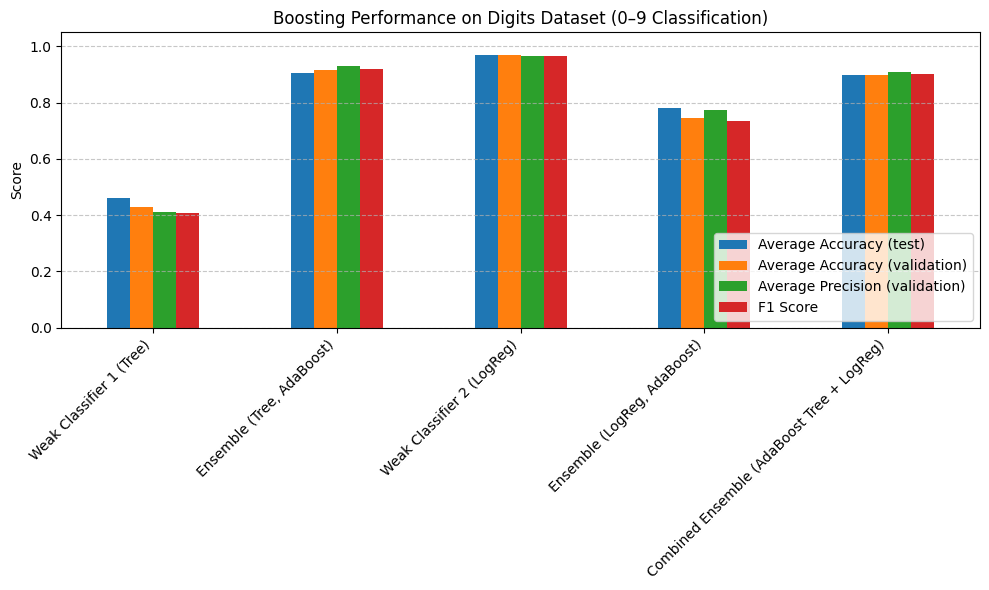

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(10, 6))
df_results[['Average Accuracy (test)', 'Average Accuracy (validation)',
            'Average Precision (validation)', 'F1 Score']].plot(kind='bar', ax=ax)
plt.title('Boosting Performance on Digits Dataset (0–9 Classification)')
plt.ylabel('Score')
plt.ylim(0, 1.05)
ax.set_xticklabels(df_results.index, rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(loc='lower right')
plt.show()